In [1]:
import logging
import os
import re
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import properscoring as ps
import requests
import xarray as xr
import xesmf as xe
from hwt import mask0p5, mask0p25
from metpy.constants import g
from utils import (
    era5_varid,
    gefs_members,
    get_graphcast_output,
    init_times,
)
from tqdm.notebook import tqdm

# Place where Dave cached datasets for quicker use
CACHEDIR = Path("/glade/derecho/scratch/ahijevyc/ldmason_hwt")

# sorted list of unique years in init_times
years = sorted(list(set(i.year for i in init_times)))

forecast_length = 240

shortName, isobaricInhPa, units = "z", 500, "m"

In [2]:
# Assumes files were created first by ens_spread_skill.ipynb

ds_mpas = (
    xr.open_zarr(CACHEDIR / f"mpas15-3km.zarr", consolidated=False)["__xarray_dataarray_variable__"]
    .to_dataset(dim="variable")
    .rename(
        lat="latitude",
        lon="longitude",
        member="number",
        t850="t",
        z500="z",
    )
    .assign_coords(
        valid_time=lambda x: x["initialization_time"] + x["forecast_hour"] * pd.Timedelta("1h")
    )
    .isel(latitude=slice(None, None, -1))
)
ds_mpas["z"] = ds_mpas["z"] / g.m
ds_fv3 = xr.open_zarr(CACHEDIR / f"fv3.zarr")
ds_gefs = xr.open_zarr(
    CACHEDIR / f"gefs.{isobaricInhPa}{shortName}.{years}.{forecast_length:03d}h.zarr",
    decode_timedelta=False,
)
ds_pangu = xr.open_zarr(
    CACHEDIR / f"pangu.{isobaricInhPa}{shortName}.{years}.{forecast_length:03d}h.zarr",
    decode_timedelta=False,
)
ds_fengwu = xr.open_zarr(
    CACHEDIR / f"fengwu.{isobaricInhPa}{shortName}.{years}.{forecast_length:03d}h.zarr",
    decode_timedelta=False,
)
ds_graphcast = get_graphcast_output(shortName, isobaricInhPa)
ds_graphcast = ds_graphcast.sel(forecast_hour=slice(None, forecast_length))

/glade/work/ahijevyc/conda-envs/daa/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:43: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)


In [3]:
era5_dir = Path("/glade/campaign/collections/rda/data/d633000/e5.oper.an.pl")

# tack on extra truth times to compare to the forecast valid times
truth_times = init_times
for init_time in init_times:
    valid_times = pd.date_range(init_time, init_time + pd.to_timedelta(f"{forecast_length}h"))
    truth_times = truth_times.union(valid_times)

era5_files = [
    era5_dir
    / i.strftime("%Y%m")
    / f"e5.oper.an.pl.128_{era5_varid[shortName]}_{shortName}.ll025sc.{i:%Y%m%d00}_{i:%Y%m%d23}.nc"
    for i in truth_times
]
truth = (
    xr.open_mfdataset(era5_files)
    .sel(level=isobaricInhPa)
    .rename(time="valid_time", level="isobaricInhPa")
    .rename({shortName.upper(): shortName})  # T->t, Z->z. uppercase shortName to lower
)
# era5 available every hour. just return 0z please
truth = truth.sel(valid_time=(truth.valid_time.dt.hour == 0))

# convert geopotential to geopotential height
if shortName == "z":
    truth["z"] = truth["z"] / g.m

In [4]:
# Apply the geographic selection to each dataset and re-assign it to the original variable
geographic_sel = dict(latitude=slice(60, 20), longitude=slice(220, 300))
# hwt_mask is a LambertConf grid within geographic_sel. Trim others to mpas hwt interp domain
ds_mpas = ds_mpas.sel(geographic_sel).where(mask0p25).load()
ds_fv3 = ds_fv3.sel(geographic_sel).where(mask0p25).load()
ds_gefs = ds_gefs.sel(geographic_sel).where(mask0p5).load()
ds_pangu = ds_pangu.sel(geographic_sel).where(mask0p25).load()
ds_fengwu = ds_fengwu.sel(geographic_sel).where(mask0p25).load()
ds_graphcast = ds_graphcast.where(mask0p25).load()
truth = truth.sel(geographic_sel).where(mask0p25).load()

In [5]:
climo_var = {"z": "hgt", "t": "air"}
climo = xr.open_dataset(
    f"/glade/work/ahijevyc/share/ACC/{climo_var[shortName]}.day.ltm.1981-2010.nc",
    decode_times=xr.coders.CFDatetimeCoder(use_cftime=True),
).rename({"lat": "latitude", "lon": "longitude"})
# Create the regridding tool
regridder = xe.Regridder(
    climo,
    xr.Dataset(
        coords={
            "latitude": ds_pangu.coords["latitude"],
            "longitude": ds_pangu.coords["longitude"],
        }
    ),
    method="bilinear",
    periodic=True,
)

# Apply the regridding to your dataset
ds_climo = regridder(climo)

# make day of year the coordinate
ds_climo = ds_climo.assign_coords(dayofyear=ds_climo.time.dt.dayofyear).swap_dims(time="dayofyear")

ds_climo = ds_climo.rename({climo_var[shortName]: shortName}).sel(level=isobaricInhPa)
ds_climo

<xarray.Dataset> Size: 151MB
Dimensions:         (dayofyear: 365, latitude: 161, longitude: 321)
Coordinates:
    level           float32 4B 500.0
    time            (dayofyear) object 3kB 0001-01-01 00:00:00 ... 0001-12-31...
  * latitude        (latitude) float64 1kB 60.0 59.75 59.5 ... 20.5 20.25 20.0
  * longitude       (longitude) float64 3kB 220.0 220.2 220.5 ... 299.8 300.0
  * dayofyear       (dayofyear) int64 3kB 1 2 3 4 5 6 ... 361 362 363 364 365
Data variables:
    z               (dayofyear, latitude, longitude) float32 75MB 5.303e+03 ....
    valid_yr_count  (dayofyear, latitude, longitude) float32 75MB 2.755e-39 ....
Attributes:
    regrid_method:  bilinear

In [6]:
anom_truth = truth.unify_chunks().groupby("valid_time.dayofyear") - ds_climo
anom_truth

<xarray.Dataset> Size: 21MB
Dimensions:        (latitude: 161, longitude: 321, valid_time: 100)
Coordinates:
  * latitude       (latitude) float64 1kB 60.0 59.75 59.5 ... 20.5 20.25 20.0
  * longitude      (longitude) float64 3kB 220.0 220.2 220.5 ... 299.8 300.0
  * valid_time     (valid_time) datetime64[ns] 800B 2023-04-24 ... 2024-06-10
    isobaricInhPa  float64 8B 500.0
    dayofyear      (valid_time) int64 800B 114 115 116 117 ... 159 160 161 162
    level          (valid_time) float32 400B 500.0 500.0 500.0 ... 500.0 500.0
    time           (valid_time) object 800B 0001-04-24 00:00:00 ... 0001-06-1...
Data variables:
    z              (valid_time, latitude, longitude) float32 21MB nan ... nan

plots/acc.z500.10memcutoff.png


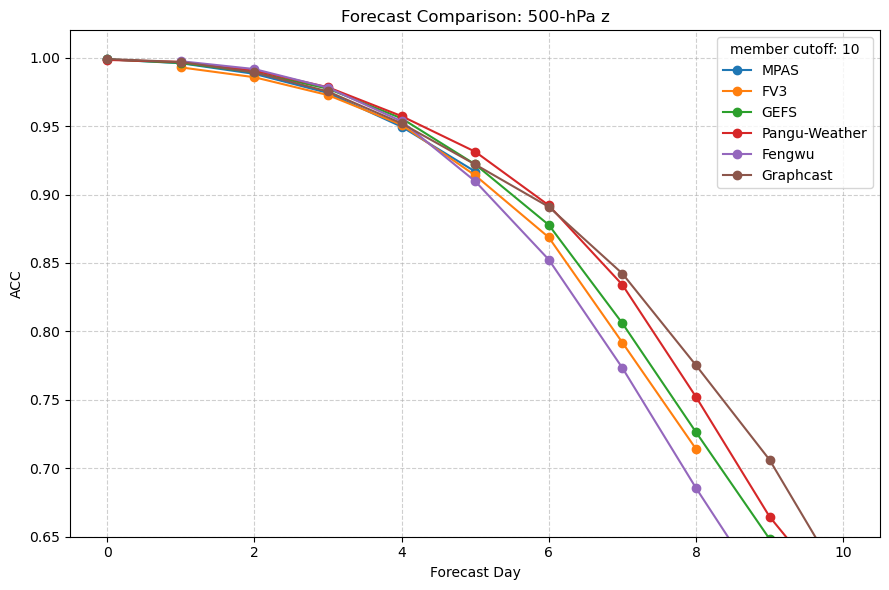

In [7]:
# Create a single figure and axes object
fig, ax = plt.subplots(figsize=(9, 6))

member_cutoff = 10

# Loop through each model to calculate and plot its ACC
for ds_model, title in zip(
    [ds_mpas, ds_fv3, ds_gefs, ds_pangu, ds_fengwu, ds_graphcast],
    ["MPAS", "FV3", "GEFS", "Pangu-Weather", "Fengwu", "Graphcast"],
):
    ds_model = ds_model.sel(number=slice(None, member_cutoff))
    # Calculate the anomaly
    anom = ds_model.groupby("valid_time.dayofyear") - ds_climo

    # Calculate the Anomaly Correlation Coefficient (ACC)
    acc = xr.corr(
        anom[shortName].mean(dim="number"),
        anom_truth[shortName].sel(valid_time=anom.valid_time),
        dim=["latitude", "longitude", "initialization_time"],
    )

    # Convert forecast_hour to days for the x-axis
    acc = acc.assign_coords(day=acc.forecast_hour / 24)

    # Plot the ACC line on the single axes, using the model title as the label
    acc.plot.line(ax=ax, x="day", marker="o", label=title)

# --- Configure the final plot ---

# Set a single title for the chart
ax.set_title(f"Forecast Comparison: {isobaricInhPa}-hPa {shortName}")

# Set labels for the axes
ax.set_ylabel(f"ACC")
ax.set_xlabel("Forecast Day")

ax.set_ylim(bottom=0.65, top=1.02)

# Add a grid and a legend
ax.grid(True, linestyle="--", alpha=0.6)
ax.legend(title=f"member cutoff: {member_cutoff}")

# Adjust layout to prevent labels from overlapping
plt.tight_layout()

ofile = f"plots/acc.{shortName}{isobaricInhPa}.{member_cutoff}memcutoff.png"
fig.savefig(ofile)
print(ofile)